# Time Series Forecasting With Prophet: Creating Input for an Optimization Model


## Introduction

The need to transition from traditional fossil fuel-based energy resources to renewable ones has intensified the adoption of solar and wind energy production. Yet, the sun is not always shining and the wind is not always blowing. When customers need energy might not coincide with those of high wind and solar potential which is a key chalenge associated with renewables energy sources. Batteries can be a solution to this problem making it possible to use energy that has been stored can be used at any time during the day by discharging the energy stored in the battery.

In this example, we will utilize solar energy with batteries to satisfy the energy demands of operating a university building and the associated courses that are taking place. In the next sections, we will describe the problem statement, and demonstrate how data science and mathematical optimization can be used to optimally solve the given problem.

The information used for this example have been adopted from [IEEE's Predict+Optimize Technical Challenge](https://ieee-dataport.org/competitions/ieee-cis-technical-challenge-predictoptimize-renewable-energy-scheduling).


## Objective and Prerequisites

In this example, we consider a single university building on campus in Melbourne, Australia that has a set of courses scheduled over the course six days (Monday - Saturday).

The building and each courses have a certain energy demand that needs to be satisfied. The buidling's energy demand is assumed to known and each of the courses has a different demand based on the resources required (e.g. class size or a lab). The building has two solar panels installed which are capable of providing energy and there is also the capability of purchasing power directly from the electricity grid to satisfy the demand. Additionally, the building is equipped with two batteries which can store the energy provided from the solar panels, and can provide this energy when needeed.

The key learning component of this project is to integrate time series data forecasting with mathematical optimization. In contrast to the other examples in this library, here we incorporate a prediction horizon for the solar forecast which will be the major input for the optimization problem.

This example is for beginners in mathematical optimization. It assumes that you have some knowledge of data handling and data-driven modeling, as well as a basic understanding of Python and using the Gurobi Python API.

The presented problem requires the installation of the following Python packages:

- **pandas**: for data analysis and manipulation
- **numpy**: for mathematical calculations
- **matplotlib**: for plotting and visualizing information
- **prophet**: for predicting the future solar output


## Problem Statement

Given a course schedule for the upcoming week and historical data about the solar potential, the objective is to determine the optimal battery charging and discharging schedule are in order to satisfy the energy demand for a building where the courses are held. The total energy demand is composed of the demand from the building itself plus the amount needed for each course. The example will look at two objectives:

- Minimize the total electricity purchased from the grid during the upcoming week
- Since elctricity prices fluctuate, minimize the total cost of electricy purchaced from the grid

At the same time, batteries have a finite capacity as well a limits on how much it can charge or discharge over a period of time. These impose constraints on the problem and make it difficult to solve. Additionally, while the solar panels can both provide electricty to meet demand directly, _each panel can charge only one battery_.

For simplicity, the time considered for each day will be limited to between 5am and 8pm. If you have access to a full Gurobi license (e.g. through our [Academic Program](https://www.gurobi.com/academia/academic-program-and-licenses/)) feel free to expand this to solve a much larger version of the problem.

Here is a view of what the week's schedule will look like:

![sched](https://github.com/Gurobi/modeling-examples/blob/master/optimization101/Modeling_Session_2/ClassSchedule.png?raw=1)

<h2> Solution Approach </h2>

The solution approach of the problem consists of two components: 1) **a forecasting component** for the solar availability and 2) **an optimization component** to determine what is the battery schedule as well as the amount of elecetricity purhcased from the grid.

Initially, we will utilize the historical information about the solar potential of the area close to the university campus to forecast the solar output for the next week at a 15 minute interval. Given this information, as well as the demand of the university building and the energy demand of each of the courses in the building, we will formulate and solve a mixted-integer programming (MIP) problem to find the optimal solution to the problem for each of the above objectives using gurobipy.


### Solar Power Forecasting


We begin our solution approach by installing and loading the necessary packages which will be needed:


In [3]:
#%pip install Prophet
#%pip install gurobipy

In [4]:
!conda info --envs

# conda environments:
#
base                     /Users/hermansolem/anaconda3
ag                       /Users/hermansolem/anaconda3/envs/ag
alpha-go                 /Users/hermansolem/anaconda3/envs/alpha-go
gurobi_example_setup  *  /Users/hermansolem/anaconda3/envs/gurobi_example_setup
jax-controller           /Users/hermansolem/anaconda3/envs/jax-controller
optimization             /Users/hermansolem/anaconda3/envs/optimization
optuna_setup             /Users/hermansolem/anaconda3/envs/optuna_setup
                         /Users/hermansolem/opt/anaconda3/envs/myenv
                         /Users/hermansolem/opt/anaconda3/envs/virtualenv
                         /Users/hermansolem/opt/miniconda3



In [5]:
!conda list

# packages in environment at /Users/hermansolem/anaconda3/envs/gurobi_example_setup:
#
# Name                    Version                   Build  Channel
anyio                     4.3.0              pyhd8ed1ab_0    conda-forge
appnope                   0.1.4              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py312h104f124_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge
black                     24.4.2          py312hb401068_0    conda-forge
bleach                    6.1.0            

In [6]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from prophet import Prophet
from prophet.diagnostics import cross_validation
from datetime import datetime
from gurobipy import Model, GRB, quicksum

The building where the classes are planned to happen has two solar panels installed on it, whose generation is loaded in the two dataframes:


In [10]:
solarData = pd.read_csv('../data/raw/SolarPanel.csv')
solarData.start_timestamp = pd.to_datetime(solarData.start_timestamp)
# make the time local to Melbourne
solarData['start_timestamp'] += pd.to_timedelta(10, unit='h')

/var/folders/r8/h1q1mkg54gn3h_wj23vwnw440000gn/T/ipykernel_93286/2004993454.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  solarData.start_timestamp = pd.to_datetime(solarData.start_timestamp)


Note that the solar power generation data are repoted in 15 minute intervals. Additionally the final date that we have data is September 30th. A visualization of the datasets is presented in the following figures:


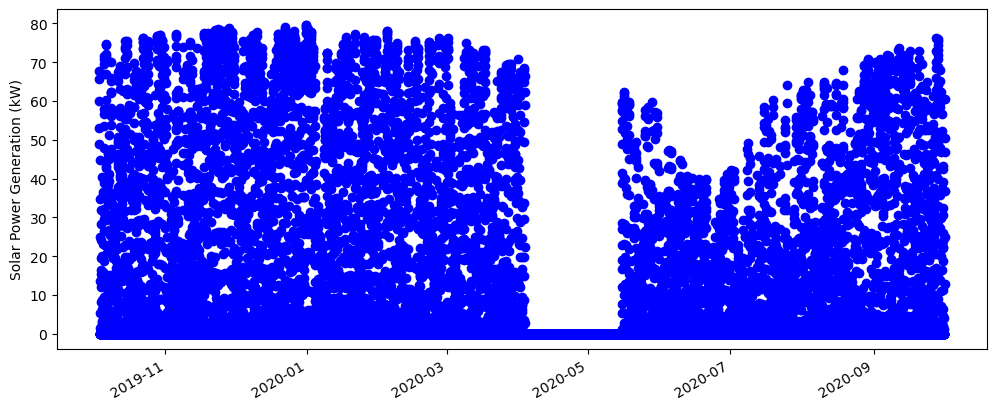

In [11]:
plt.figure(figsize=(12,5))
plt.scatter(solarData.start_timestamp, solarData.series_values, c='blue')
plt.gcf().autofmt_xdate()
plt.ylabel('Solar Power Generation (kW)');

The above visuals give a sense of the solar generation range and overall trend for each panel, but it is difficult to see what is happening at the 15-minute level we will build our forecasting and optimization solution around. The plot below shows solar genration for each 15-minute interval for two consecutive days. Change the date and time below to see how the solar output changes.


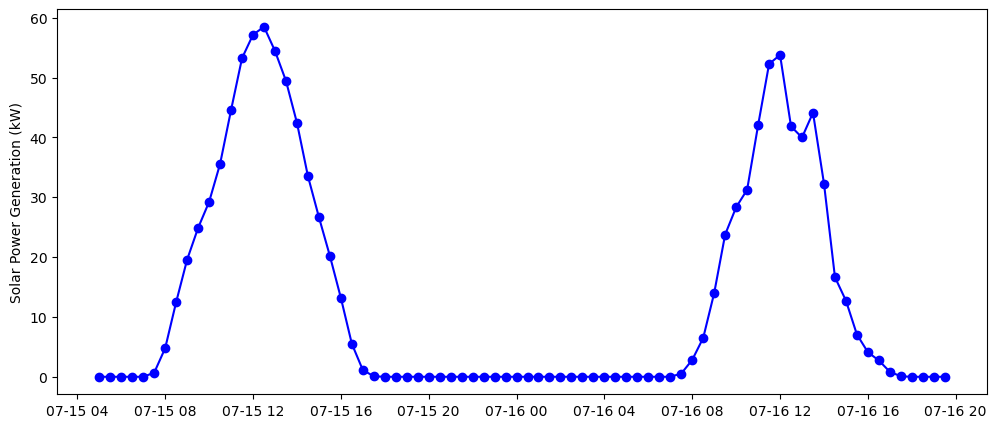

In [12]:
start_date = '2020-07-15 05:00:00'
end_date = '2020-07-16 19:45:00'
plt.figure(figsize=(12,5))
plt.plot(solarData.start_timestamp[(solarData.start_timestamp >= start_date) & (solarData.start_timestamp < end_date)], 
           solarData.series_values[(solarData.start_timestamp >= start_date) & (solarData.start_timestamp < end_date)], '-o', c='blue')
plt.ylabel('Solar Power Generation (kW)');

Going back to the first figures, you may have noticed data for each solar panel that seems incorrect. In the first panel generation over an approximate one month period is a diagonal line and for the second panel the gernation is constant at zero. The following figures show this pattern and the dates/times in which is occurs.


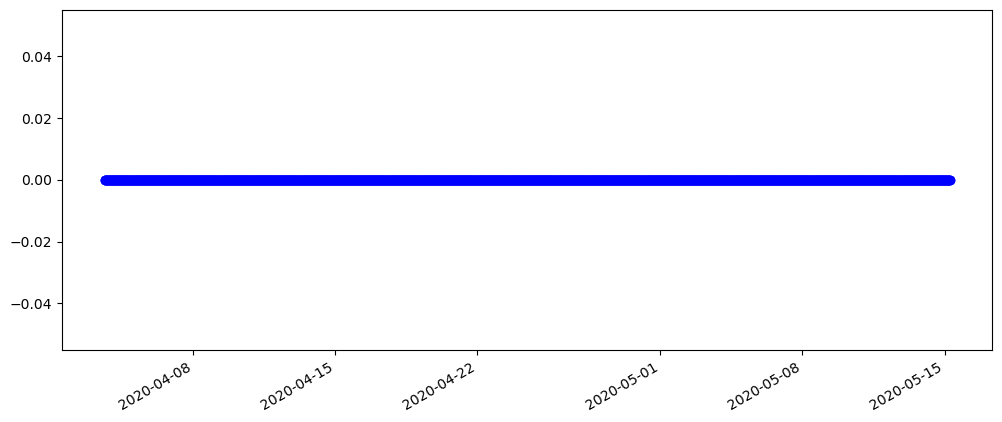

In [13]:
s0 = solarData[(solarData.start_timestamp >= '2020-04-03 15:30:00') & (solarData.start_timestamp < '2020-05-15 07:00:00')]
plt.figure(figsize=(12,5))
plt.scatter(s0.start_timestamp, s0.series_values, c='blue')
plt.gcf().autofmt_xdate()

We will remove these points later on in the example as they do no fit with the general daily pattern we saw earlier.

In this example, we will utilize Facebook's Prophet time series forecasting to forecast the upcoming solar generation. Prophet is convenient to use and also it has been shown to be perform satisfactorily in multiple instances for these types of problems.

The training data are set to comply with Prophet's format and then we will use the derived model to derive a forecast of solar output for the next week. Finally, we crop the forecasts for our desired time of Monday, October 5th through Saturday, October 10th in 2020.


In [14]:
solarB = pd.DataFrame()
solarB['ds'] = solarData.start_timestamp
solarB['y'] = solarData.series_values
solarB = solarB.loc[~solarB.index.isin(s0.index)]
modelB = Prophet(changepoints=['2019-11-01','2019-12-01','2020-01-01','2020-02-01','2020-03-01','2020-06-01','2020-07-01','2020-08-01','2020-09-01'])
modelB.add_seasonality(name='daily', period=1, fourier_order=5, prior_scale=10, mode = 'multiplicative')
modelB.fit(solarB)
futureB = modelB.make_future_dataframe(periods=452, freq='30min')
forecastB = modelB.predict(futureB)

18:54:31 - cmdstanpy - INFO - Chain [1] start processing
18:54:34 - cmdstanpy - INFO - Chain [1] done processing


RMSE:10.193196 MAE:5.947611


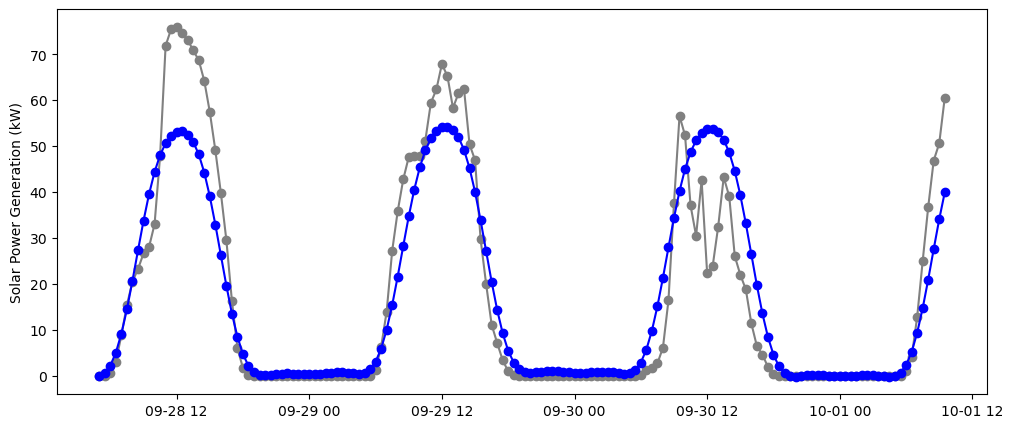

In [15]:
diff = solarB.merge(forecastB[['ds','yhat']])
rmse = np.sqrt(np.mean(np.square(diff.y - diff.yhat)))
mae = np.mean(np.abs(diff.y - diff.yhat))
print(f"RMSE:{round(rmse,6)} MAE:{round(mae,6)}")
plt.figure(figsize=(12,5))
plt.plot(diff.ds[diff.ds >= '2020-09-28 05:00:00'], diff.y[diff.ds >= '2020-09-28 05:00:00'], '-o', c = 'grey')
plt.plot(diff.ds[diff.ds >= '2020-09-28 05:00:00'], diff.yhat[diff.ds >= '2020-09-28 05:00:00'], '-o', c = 'blue')
plt.ylabel('Solar Power Generation (kW)');

In [17]:
forecastB_October = forecastB[(forecastB.ds >= '2020-10-05')]
forecastB_October = forecastB_October.set_index('ds')
forecastB_October_Optimization = forecastB_October.copy().between_time('05:00:00','19:30:00')
forecastB_October_Optimization.iloc[forecastB_October_Optimization.yhat < 0,] = 0

# This is the output file we'll use in the optimization model
forecastB_October_Optimization.to_csv('../data/processed/pred_solar_values_2.csv', index = False)

Copyright © 2022 Gurobi Optimization, LLC
